<a href="https://colab.research.google.com/github/poojamahajan0712/medium_blog/blob/master/CIFAR_Resnet/Resnet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#1. Importing libraries
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

import resnet


In [4]:
##  Transformations
trans=transforms.Compose(
    [transforms.RandomHorizontalFlip(),  
     transforms.RandomRotation(10),  
     transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),  
     transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 

In [5]:
# Loading CIFAR dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=trans)
    
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=trans)
    
dataloader_args = dict(shuffle=True, batch_size=200, num_workers=4, pin_memory=True)
    
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
    
testloader = torch.utils.data.DataLoader(testset,**dataloader_args)
    
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 ship  bird  ship   cat


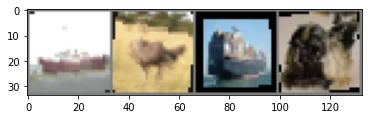

In [6]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
# show images
imshow(torchvision.utils.make_grid(images[:4],padding=1))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
# Model Summary - Resnet 18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = resnet.ResNet18().to(device)
print(summary(net, input_size=(3,32,32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [11]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
for epoch in range(1,11):
    print('Epoch',epoch)
    train(net, device, trainloader, optimizer, epoch,criterion)
    test(net, device, testloader,criterion)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1


Loss=0.007381048984825611 Batch_id=249 Accuracy=98.81: 100%|██████████| 250/250 [00:37<00:00,  6.75it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8747/10000 (87.47%)

Epoch 2


Loss=0.05240644887089729 Batch_id=249 Accuracy=98.63: 100%|██████████| 250/250 [00:36<00:00,  6.94it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8788/10000 (87.88%)

Epoch 3


Loss=0.05909895896911621 Batch_id=249 Accuracy=98.80: 100%|██████████| 250/250 [00:36<00:00,  6.81it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8778/10000 (87.78%)

Epoch 4


Loss=0.055371418595314026 Batch_id=249 Accuracy=98.70: 100%|██████████| 250/250 [00:36<00:00,  6.91it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8776/10000 (87.76%)

Epoch 5


Loss=0.02206704579293728 Batch_id=249 Accuracy=98.70: 100%|██████████| 250/250 [00:36<00:00,  6.92it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8773/10000 (87.73%)

Epoch 6


Loss=0.028247898444533348 Batch_id=249 Accuracy=98.75: 100%|██████████| 250/250 [00:36<00:00,  6.92it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8829/10000 (88.29%)

Epoch 7


Loss=0.02366724982857704 Batch_id=249 Accuracy=98.88: 100%|██████████| 250/250 [00:36<00:00,  6.92it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8763/10000 (87.63%)

Epoch 8


Loss=0.016313036903738976 Batch_id=249 Accuracy=98.81: 100%|██████████| 250/250 [00:35<00:00,  6.95it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8804/10000 (88.04%)

Epoch 9


Loss=0.042202893644571304 Batch_id=249 Accuracy=98.85: 100%|██████████| 250/250 [00:36<00:00,  6.90it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8759/10000 (87.59%)

Epoch 10


Loss=0.014895021915435791 Batch_id=249 Accuracy=98.90: 100%|██████████| 250/250 [00:36<00:00,  6.77it/s]



Test set: Average loss: 0.0028, Accuracy: 8749/10000 (87.49%)



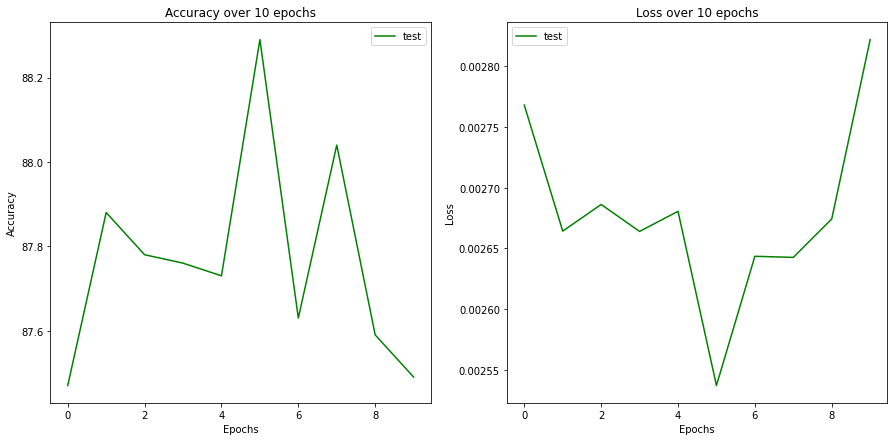

In [14]:


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.plot(test_acc, color="green", label="test")
ax1.set_title("Accuracy over 10 epochs")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()


ax2.plot(test_losses, color="green", label="test")
ax2.set_title("Loss over 10 epochs")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

